1) Read in all files
2) See how many 0's, 1's
3) Analyze file (see the average length) 

In [3]:
import os
import pathlib

data_path = os.path.join(os.getcwd(),"data")
print(data_path)
for dirName, subdirList, fileList in os.walk(data_path):
    zeros = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '0']
    ones = [f for f in fileList if f.split(".csv")[0].split("_",2)[2] == '1']
print(f"Zeros: {len(zeros)}\nOnes: {len(ones)}")    

c:\Users\m.litton_local\ca_disengagement\data
Zeros: 2
Ones: 4


In [5]:
import pandas as pd

all_files = zeros + ones
file_lengths = []
for f in all_files:
    df = pd.read_csv(os.path.join(data_path,f))
    file_lengths.append(df.shape[0])
pd.Series(file_lengths).describe()


count      6.000000
mean     410.500000
std       52.447116
min      322.000000
25%      391.750000
50%      416.000000
75%      450.750000
max      463.000000
dtype: float64

4) For each file, take 5 seconds before and 1 second after the event of interest (sampling every 0.5 seconds)

In [10]:
sample_interval = 0.5
seconds_before = 5
seconds_after = 1

all_seqs = []
for file in all_files:
    df = pd.read_csv(os.path.join(data_path,file),index_col=0)
    #look at the cases where the adversary is in front of ego
    in_front = df[df['angle'].abs() < 5]
    if(in_front.shape[0]>0):
        min_dist = in_front['distance'].min()
        min_dist_idx = in_front['distance'].idxmin()
    else:
        min_dist = df['distance'].min()
        min_dist_idx = df['distance'].idxmin()
    start_idx = min_dist_idx - seconds_before * (2*sample_interval/0.05)
    stop_idx = min_dist_idx + seconds_after * (2*sample_interval/0.05)

    indices_to_sample = []
    for x in range(int(start_idx),int(stop_idx+1),int(sample_interval/0.05)): indices_to_sample.append(x)

    columns_of_interest = ['distance','angle',
        'ego_vel_x','ego_vel_y','ego_vel_z','ego_accel_x','ego_accel_y','ego_accel_z','ego_ang_vel_x','ego_ang_vel_y','ego_ang_vel_z',
        'adv_vel_x','adv_vel_y','adv_vel_z','adv_accel_x','adv_accel_y','adv_accel_z','adv_ang_vel_x','adv_ang_vel_y','adv_ang_vel_z']
    try:
        rows_of_interest = df.loc[indices_to_sample,columns_of_interest]
    except:
        print(f"bad keys in file {file}")
        print(indices_to_sample)
        continue
    one_seq = []
    for index, rows in rows_of_interest.iterrows():
        for elem in rows:
            one_seq.append(elem)
    one_seq.append(file.split(".csv")[0].split("_",2)[2])
    all_seqs.append(one_seq)

full_df = pd.DataFrame(all_seqs, columns=(columns_of_interest * 13 + ['class']))
full_df.to_csv(os.path.join(os.getcwd(),"classifier_data\\labeled_data.csv"),index=None)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Columns: 261 entries, distance to class
dtypes: float64(260), object(1)
memory usage: 12.4+ KB


5) Generate Train/Test Files

In [12]:
from sklearn.model_selection import train_test_split
x = full_df.iloc[:,:-1]
y = full_df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)
train = x_train.assign(Class=y_train)
test = x_test.assign(Class=y_test)
train.to_csv(os.path.join(os.getcwd(),"classifier_data\\train_file.csv"),index=None)
test.to_csv(os.path.join(os.getcwd(),"classifier_data\\test_file.csv"),index=None)


In [13]:
x_train.head()

,distance,angle,ego_vel_x,ego_vel_y,ego_vel_z,ego_accel_x,ego_accel_y,ego_accel_z,ego_ang_vel_x,ego_ang_vel_y,...,ego_ang_vel_z,adv_vel_x,adv_vel_y,adv_vel_z,adv_accel_x,adv_accel_y,adv_accel_z,adv_ang_vel_x,adv_ang_vel_y,adv_ang_vel_z
5,2.394402,-92.699065,2.213269,-0.004820,0.008226,0.965323,0.034660,0.005624,0.031928,0.247314,...,4.661199,2.579884,0.586424,0.038956,-1.595778,-0.613381,0.057812,2.309749,0.050518,7.780917
0,3.315200,-32.150837,2.087571,-0.006118,0.001819,0.528011,-0.043070,0.010534,0.049604,0.104988,...,-0.909080,3.764005,-0.140541,0.082125,0.949435,-0.054162,0.019150,0.311968,-0.159733,-11.318643
3,0.897578,-94.899875,2.120662,-0.006087,0.012148,-1.118417,-0.031779,-0.017178,-0.041992,-0.529649,...,4.490964,2.405383,0.449374,0.042512,-0.143337,-0.122161,0.009461,3.443107,0.518790,6.943606
2,0.399264,-133.866643,2.074257,-0.005956,-0.000302,0.250907,-0.042951,0.008790,0.032592,0.061778,...,8.390506,2.411951,0.380962,0.016738,-0.283861,-0.342909,0.023494,0.467824,-0.536114,5.686166


In [14]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

RF = RandomForestClassifier()
RF.fit(x_train,y_train)
RF.score(x_test,y_test)

0.5

[(157, 'adv_ang_vel_x', 0.04477611940298507), (255, 'adv_accel_y', 0.029850746268656716), (73, 'adv_vel_z', 0.029850746268656716), (172, 'adv_vel_y', 0.029850746268656716), (230, 'ego_ang_vel_z', 0.029850746268656716), (18, 'adv_ang_vel_y', 0.029850746268656716), (187, 'ego_accel_z', 0.029850746268656716), (259, 'adv_ang_vel_z', 0.014925373134328358), (56, 'adv_accel_z', 0.014925373134328358), (169, 'ego_ang_vel_y', 0.014925373134328358), (171, 'adv_vel_x', 0.014925373134328358), (173, 'adv_vel_z', 0.014925373134328358), (180, 'distance', 0.014925373134328358), (53, 'adv_vel_z', 0.014925373134328358), (51, 'adv_vel_x', 0.014925373134328358), (192, 'adv_vel_y', 0.014925373134328358), (194, 'adv_accel_x', 0.014925373134328358), (44, 'ego_vel_z', 0.014925373134328358), (203, 'ego_vel_y', 0.014925373134328358), (205, 'ego_accel_x', 0.014925373134328358)]
77.3076923076923


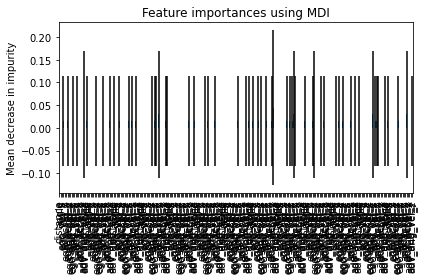

In [15]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
feature_names=x_test.columns.values.tolist()
forest_importances = pd.Series(importances, index=feature_names)

#print(np.sort(importances)[::-1])
sorted_importances = np.argsort(importances)[::-1]
sorted_tuple = [(i,feature_names[i],importances[i]) for i in sorted_importances]
print(sorted_tuple[:20])
print(len([x for x in sorted_tuple if x[2]==0])/len(sorted_tuple) * 100)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


